# Dense Layer

In [ ]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data
nnfs.init()
#dense layer
class dense_layer:
  def __init__(self, n_inputs, n_neurons):
    self.weights = 0.001 * np.random.randn(n_inputs, n_neurons) #n_inputs, n_neurons - size of weight matrix
    self.biases = np.zeros((1, n_neurons))

  #forward pass
  def fpass(self, inputs):
    self.output = np.dot(inputs, self.weights) + self.biases

  #dataset
x, y = spiral_data(samples = 100, classes = 3)
dense1 = dense_layer(2, 3) #2 features(x-dim & y-dim), 100 samples, 3 classes
dense1.fpass(x)

print(dense1.output[:5])


[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [-1.0475188e-05  1.1395361e-05 -4.7983503e-06]
 [-2.7414844e-05  3.1729149e-05 -8.6921800e-06]
 [-4.2188371e-05  5.2666255e-05 -5.5912687e-06]
 [-5.7707683e-05  7.1401402e-05 -8.9430441e-06]]


#NN A-Z Scratch

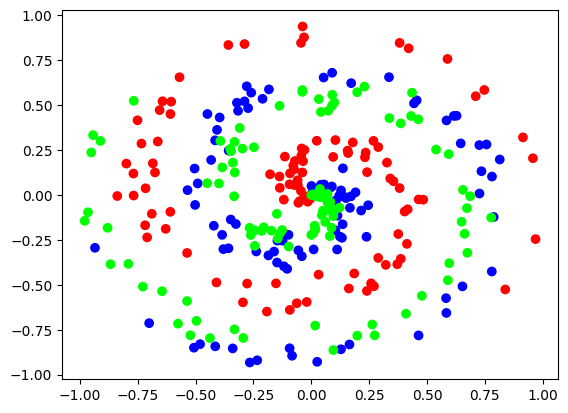

In [ ]:
!pip install nnfs
import numpy as np
import nnfs
from nnfs.datasets import spiral_data
nnfs.init()

import matplotlib.pyplot as plt
X, y = spiral_data(samples=100, classes = 3)
plt.scatter(X[:,0], X[:,1], c=y, cmap='brg')
plt.show()
#

In [ ]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data
nnfs.init()
#dense layer
class dense_layer:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.001 * np.random.randn(n_inputs, n_neurons)  # n_inputs, n_neurons - size of weight matrix
        self.biases = np.zeros((1, n_neurons))

    # Forward pass
    def fpass(self, inputs):
        self.inputs = inputs  # Store inputs for use in the backward pass
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass
    def bpass(self, dvalues):  # dvalues -> partial derivatives of loss w.r.t layer outputs
        self.dweights = np.dot(self.inputs.T, dvalues)  # Use self.inputs now
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)  # Sum dbiases row since it affects result directly
        self.dinputs = np.dot(dvalues, self.weights.T)  # dinputs -> partial derivatives of loss w.r.t inputs





In [ ]:
#RELU ACTIVATION

class relu_activation:
  def fpass(self, inputs):
    self.inputs = inputs
    self.output = np.maximum(0, inputs)

    #backward pass
  def bpass(self, dvalues):
    self.dinputs = dvalues.copy()
    self.dinputs[self.inputs <= 0] = 0


In [ ]:
 #softmax ACTIVATION
class softmax_activation:
  def fpass(self, inputs):
    #unnormalized probability
    exp_values=np.exp(inputs - np.max(inputs, axis=1, keepdims=True)) #subtract from max to produce probabilities btw 0-1
    #normalized probability
    probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
    self.output = probabilities






In [ ]:
class Loss:
 # Calculates the data and regularization losses
 # given model output and ground truth values
 def calculate(self, output, y):
  # Calculate sample losses
  sample_losses = self.forward(output, y)
  # Calculate mean loss
  data_loss = np.mean(sample_losses)
  # Return loss
  return data_loss

In [ ]:
#loss function

class loss_cross_entropy:
  def fpass(self, y_pred, y_true):
    samples = len(y_pred)

    #clip to avoid division by 0 or values going to either extremes so mean doesnot go either way
    y_pred_clip = np.clip(y_pred, 1e-7, 1-1e-7)

    #if single row given it will look for samples in each row of pred
    if len(y_true.shape) == 1:
      correct_conf = y_pred_clip[range(samples), y_true]

    #if one-hot encoded matrix given it will multiply
    elif len(y_true.shape) == 2:
      correct_conf = np.sum(y_pred_clip * y_true, axis = 1)


    #loss for each batch of data
    loss_batch = -np.log(correct_conf)
    return loss_batch





In [ ]:
#softmax activation & loss for backward pass
# divide predictions to avoid gradient explosion
# softmax activation & loss for backward pass
class softmax_loss_combined:
    def __init__(self):
        self.activation = softmax_activation()
        self.loss = loss_cross_entropy()
        self.dinputs = None  # Initialize dinputs

    # forward pass
    def fpass(self, inputs, y_true):
        self.activation.fpass(inputs)
        self.output = self.activation.output  # softmax
        return self.loss.fpass(self.output, y_true)  # loss

    # backward pass
    def bpass(self, dvalues, y_true):
        samples = len(dvalues)
        if len(y_true.shape) == 2:
            # labels onehot encoded
            y_true = np.argmax(y_true, axis=1)

        # Initialize dinputs here to avoid accessing it when it hasn't been set
        self.dinputs = dvalues.copy()

        # Gradient
        self.dinputs[range(samples), y_true] -= 1  # subtract 1 to adjust the gradient predicted - truth
        self.dinputs = self.dinputs / samples  # divide to prevent gradient explosion contributed by each batch of data



#combined since bpass leads to same answer






In [ ]:
#adam optimizer
class optimizer_adam:
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):
        # Create cache array if not present in layer
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update momentum with current gradient
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases

        # Get corrected momentum
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

        # Update cache with squared gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights ** 2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases ** 2

        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        # Vanilla param update + normalization
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)

    def post_update_params(self):
        self.iterations += 1


In [ ]:
X, y = spiral_data(samples=100, classes=3)

dense1 = dense_layer(2, 64) #2inputs 64 neurons

activation1 = relu_activation()

dense2 = dense_layer(64, 3) #64 inputs from pvs layer and 3 neurons

loss_activation = softmax_loss_combined()

optimizer = optimizer_adam(learning_rate=0.02, decay=1e-5)


for epoch in range(10001):
  dense1.fpass(X)
  activation1.fpass(dense1.output)
  #first layer out second layer input
  dense2.fpass(activation1.output)
  #pass to softmax true value and output + calculate loss
  loss = loss_activation.fpass(dense2.output, y)
  #calculate accuracy
  predictions = np.argmax(loss_activation.output, axis=1)
  if len(y.shape) == 2:
    y = np.argmax(y, axis=1)
  accuracy = np.mean(predictions==y)

  if not epoch % 100:
    print(f'epoch: {epoch}, '
          f'acc: {accuracy:.3f}, '
          f'loss: {loss.mean():.3f}, '  # Use loss.mean() to ensure it is a scalar
          f'lr: {optimizer.current_learning_rate:.5f}')  # Format learning rate for clarity

  #backwardpass
  loss_activation.bpass(loss_activation.output, y) #partial derivatives with softmax input
  dense2.bpass(loss_activation.dinputs) #PD with wieght, bias and input of second layer
  activation1.bpass(dense2.dinputs) #PD with relu input
  dense1.bpass(activation1.dinputs) #PD with wieght, bias and input of first layer

  #update weight + biases using optimiz
  optimizer.pre_update_params()
  optimizer.update_params(dense1)
  optimizer.update_params(dense2)
  optimizer.post_update_params()




epoch: 0, acc: 0.347, loss: 1.099, lr: 0.02000
epoch: 100, acc: 0.523, loss: 0.991, lr: 0.01998
epoch: 200, acc: 0.600, loss: 0.886, lr: 0.01996
epoch: 300, acc: 0.597, loss: 0.836, lr: 0.01994
epoch: 400, acc: 0.600, loss: 0.782, lr: 0.01992
epoch: 500, acc: 0.620, loss: 0.743, lr: 0.01990
epoch: 600, acc: 0.667, loss: 0.707, lr: 0.01988
epoch: 700, acc: 0.707, loss: 0.677, lr: 0.01986
epoch: 800, acc: 0.713, loss: 0.652, lr: 0.01984
epoch: 900, acc: 0.723, loss: 0.626, lr: 0.01982
epoch: 1000, acc: 0.750, loss: 0.609, lr: 0.01980
epoch: 1100, acc: 0.760, loss: 0.592, lr: 0.01978
epoch: 1200, acc: 0.777, loss: 0.574, lr: 0.01976
epoch: 1300, acc: 0.770, loss: 0.566, lr: 0.01974
epoch: 1400, acc: 0.783, loss: 0.550, lr: 0.01972
epoch: 1500, acc: 0.777, loss: 0.539, lr: 0.01970
epoch: 1600, acc: 0.783, loss: 0.531, lr: 0.01969
epoch: 1700, acc: 0.777, loss: 0.521, lr: 0.01967
epoch: 1800, acc: 0.780, loss: 0.514, lr: 0.01965
epoch: 1900, acc: 0.787, loss: 0.507, lr: 0.01963
epoch: 2000,

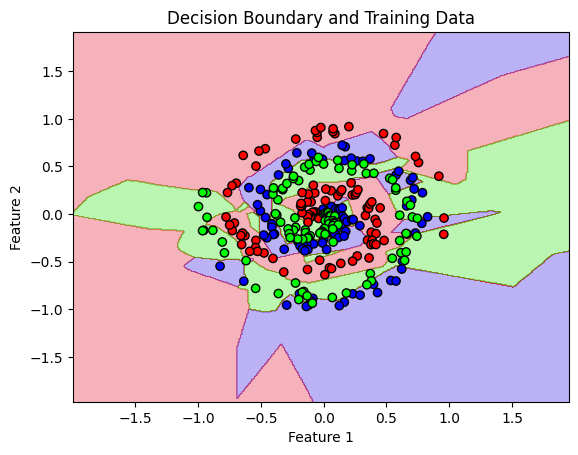

In [ ]:
def plot_decision_boundary(dense1, activation1, dense2, X, y):
    # Create a mesh grid based on the input data
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Prepare the mesh grid for prediction
    mesh_points = np.c_[xx.ravel(), yy.ravel()]  # Shape (N, 2)

    # Pass through the first layer (dense1) then through the activation (ReLU)
    dense1.fpass(mesh_points)  # First dense layer
    activation1.fpass(dense1.output)  # ReLU activation
    dense2.fpass(activation1.output)  # Second dense layer (output layer)

    # Get the predicted classes
    Z = np.argmax(dense2.output, axis=1)  # Get the predicted classes
    Z = Z.reshape(xx.shape)  # Reshape Z back to the grid shape

    # Plot the decision boundary
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='brg')

    # Plot the training data
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', cmap='brg')
    plt.title("Decision Boundary and Training Data")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

# After training the model, call the function to plot
# Note: Pass both the dense layers and activation function for the decision boundary calculation
plot_decision_boundary(dense1, activation1, dense2, X, y)
